In [1]:
# %load template.py
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import json
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pdal
import PIL
import pyproj
import requests
import fiona
import shapely.geometry
from shapely.geometry import Polygon, mapping
import scipy.spatial
import sys
import urllib.request

%load_ext autoreload
%autoreload 2
    
sys.path.append('../src')
from pcl_utils import local_max

# Url for aerial imagery
# IVaerial = "https://geoservices.informatievlaanderen.be/raadpleegdiensten/ogw/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&CRS=EPSG:31370&BBOX={0},{1},{2},{3}&WIDTH=512&HEIGHT=512&LAYERS=OGWRGB13_15VL&STYLES=default&FORMAT=image/png"

%matplotlib inline

### Work with qgis on project NewZealand_Strikes
#### Download New Zealand lidar from <a href="https://www.opentopography.org">OpenTopography</a>

work with the 3 las files
-first draw each of their boundarys in qgis

<div>
    Process lidar data for Mt Magneto site. 3 files cover the area. They are from 2 different tile sets available at the OpenTopography site. DEMS are available from the <span><a href='https://www.linz.govt.nz/data'>LINZ</a></span> site for New Zealand data. This site shows the lidar coverage at my main site Mt Magneto. Alas so dissappointed that their index tiles do not all have full coverage at perimeter areas - argh. So am adding in Arrow River site at the end of this notebook.
</div>

In [2]:
file1 = "/media/thistle/Passport/gis/nz/lidar/points1.las" # small site discovered to be covered by file3 **see below
file2 = "/media/thistle/Passport/gis/nz/lidar/points2.las"
file3 = "/media/thistle/Passport/gis/nz/lidar/points3.las"

#### data for this project can be found at two locations
* /media/thistle/Passport/gis/nz
- /home/thistle/Documents/dev/ML/gis_project/data

In [ ]:
# extract bbox info and write to files as a dictionary object

In [3]:
!pdal info $file1 | jq .stats.bbox.native.bbox > ../data/file1_bb.txt
!pdal info $file2 | jq .stats.bbox.native.bbox > ../data/file2_bb.txt
!pdal info $file3 | jq .stats.bbox.native.bbox > ../data/file3_bb.txt

In [6]:
with open("../data/file1_bb.txt") as f:
    f1_text = f.read()
f1 = json.loads(f1_text)

In [7]:
with open("../data/file2_bb.txt") as f:
    f2_text = f.read()
f2 = json.loads(f2_text)

In [8]:
with open("../data/file3_bb.txt") as f:
    f3_text = f.read()
f3 = json.loads(f3_text)

In [9]:
f2

{'maxx': 1275059.08,
 'maxy': 5006165.45,
 'maxz': 1644.3,
 'minx': 1273657.62,
 'miny': 5004077.6,
 'minz': 851.49}

In [4]:
def make_poly(bbox):
        poly = Polygon([(bbox["maxx"], bbox['maxy']), (bbox["maxx"], bbox['miny']), (bbox["minx"], bbox['miny']), (bbox["minx"], bbox['maxy']), (bbox["maxx"], bbox['maxy'])])
        return poly

In [11]:
f1poly = make_poly(f1)
f2poly = make_poly(f2)
f3poly = make_poly(f3)

In [12]:
# write a shape file with three files

In [5]:
from fiona.crs import from_epsg
from collections import OrderedDict
nz_crs = from_epsg(2193)

In [14]:
type(f1poly)

shapely.geometry.polygon.Polygon

In [ ]:
new_filepath = "../data/lidar_tiles.shp"
schema = {
    'geometry': 'Polygon',
    'properties': OrderedDict([('name', 'str')])  
}

In [56]:
with fiona.open(new_filepath, "w", driver="ESRI Shapefile", crs=nz_crs, schema=schema) as f:
    f.write({
        "geometry": mapping(f1poly),
        "properties":{"name": "one"}
    })
    f.write({
        "geometry": mapping(f2poly),
        "properties":{"name": "two"}
    })
    f.write({
        "geometry": mapping(f3poly),
        "properties":{"name": "three"}
    })

In [ ]:
#  To ensure the order of the attribute fields is predictable, in both the schema and the actual manifestation as feature attributes, we should use ordered dictionaries.
#  But with only one property who cares right?

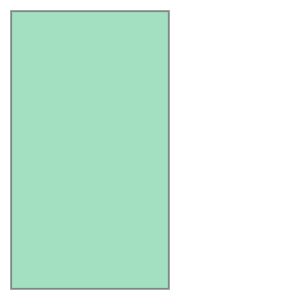

In [15]:
f3poly.intersection(f1poly)

In [16]:
f3poly.intersection(f1poly).area

2942804.2875001696

In [17]:
f3poly.area

17797382.641400635

In [18]:
f1poly.area

2942804.2875001696

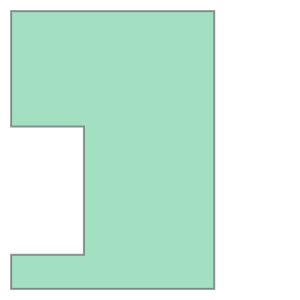

In [19]:
f3poly.difference(f1poly) # I knew it!!

Appears the lidar tile index does not properly show full extent of each tile. How I picked a place that was sandwiched in between available lidar sets is so typical.


In [20]:
# so I will just show them all
# also get another .las file for area on Arrow River downstream from town.
# add this new .las file as a feature for the lidar index shapefile I created above.

In [22]:
file4 = "/media/thistle/Passport/gis/nz/lidar/points4.las"
!pdal info $file4 | jq .stats.bbox.native.bbox > ../data/file4_bb.txt


In [12]:
with open('../data/file4_bb.txt') as f:
    temp = f.read()
    
p4 = json.loads(temp)
poly4 = make_poly(p4)

In [13]:
# should be a little easier to append than create from scratch-
shapefile_filepath = "../data/lidar_tiles.shp"
with fiona.open(shapefile_filepath, "a") as f:
    print(len(f))
    f.write({
        "geometry": mapping(poly4),
        "properties":{"name": "four"}
    })
    print(len(f))

4
5


In [30]:
poly4 = make_poly(p4)

In [35]:
# should be a little easier to append than create from scratch-
shapefile_filepath = "../data/lidar_tiles.shp"
with fiona.open(shapefile_filepath, "a") as f:
    print(len(f))
    f.write({
        "geometry": mapping(poly4),
        "properties":{"name": "four"}
    })
    print(len(f))

3
4


In [ ]:
### oops now have to remove a shape in the shapefile because I ran the above cell twice

In [7]:
feat4_fp = "/media/thistle/Passport/gis/nz/lidar/points4.las" # Arrow River site

In [22]:
# dem pipeline
pipe = {
    "pipeline":[
        {
            "type": "readers.las",
            "filename": feat4_fp
        },
        {    "type":"filters.outlier",
           "method":"statistical",
           "mean_k":"8",
           "multiplier":"3"
      },
      {
          "type":"filters.smrf"
      },
      {
          "type":"filters.range",
          "limits":"Classification[2:2]"
      },
      {
          "type":"filters.delaunay"
      },
      {
        "type": "writers.gdal",
        "gdaldriver": "GTIFF",
        "output_type": "all",
        "resolution": "2.0",
        "filename": "../data/nz_arrow1.tif"
      }
    ]
}

In [ ]:
# it worked
# so finish the dem and hillshade and call it good

In [23]:
p = pdal.Pipeline(json.dumps(pipe))
p.validate()

True

In [24]:
np = p.execute()
print(f"{np} points processed")

13483395 points processed


In [30]:
# now the hillshadeing
!gdaldem hillshade ../data/nz_arrow1.tif ../data/nz_arrow1_hs1.tif -z 1.0 -s 1.0 -az 315.0 -alt 45.0 -of GTiff

0...10...20...30...40...50...60...70...80...90...100 - done.


In [29]:
# try 180 degree rotation for the hillshade
!gdaldem hillshade ../data/nz_arrow1.tif ../data/nz_arrow1_hs2.tif -z 1.0 -s 1.0 -az 135.0 -alt 45.0 -of GTiff

0...10...20...30...40...50...60...70...80...90...100 - done.


In [39]:
p2 = pdal.Pipeline(json.dumps(pipe2))
p2.validate()

True

In [40]:
%%time
np = p2.execute()
print(f"{np} points proccessed")

13483395 points proccessed
CPU times: user 48.8 s, sys: 2.62 s, total: 51.5 s
Wall time: 51.3 s


In [ ]:
# ../data/nz_arrow_test1.tif is a test run without statitstical outliers removed
# also found that if I use filters.poisson and not delaunay I get a gdal error say my tif file exceeds max bounds
# guessing it might be benifical to pdal tindex this large file before applying complex viewing ops
# so view the new file and--> still get the wierd noground/filler problem

In [ ]:
# data removed. tests unsucessful

In [8]:
# try pipeline without outlier removeal and a different meshing algorithm
pipe3 = {
    "pipeline":[
        {
            "type": "readers.las",
            "filename": feat4_fp
        },
      {
          "type":"filters.smrf"
      },
      {
          "type":"filters.range",
          "limits":"Classification[2:2]"
      },
    {
        "type": "filters.greedyprojection",
        "multiplier": 2,
        "radius": 20
    },
      {
        "type": "writers.gdal",
        "gdaldriver": "GTIFF",
        "output_type": "all",
        "resolution": "2.0",
        "filename": "../data/nz_arrow_test1.tif"
      }
    ]
}

In [9]:
p_3 = pdal.Pipeline(json.dumps(pipe3))
p_3.validate()

True

In [10]:
%%time
num = p_3.execute()
print(f"{num} points processed")

13483395 points processed
CPU times: user 43min 52s, sys: 9.6 s, total: 44min 2s
Wall time: 43min 47s


I thought the above greedyprojection filter with radius double to 20 might help
fill in missing areas with lots of missing ground points. It sure took a long time.

In [14]:
!gdaldem hillshade ../data/nz_arrow1.tif ../data/nz_arrow2_hs1.tif -z 1.0 -s 1.0 -az 135.0 -alt 45.0 -of GTiff

0...10...20...30...40...50...60...70...80...90...100 - done.


### I would say there is not a noticable difference between the two hillshade algorithms. Except obviously timewise.

# all tif files stored @ /home/thistle/Documents/dev/ML/gis_project/data

## accomponing this notebook is the qgis project located @ 
### /media/thistle/Passport/gis/nz/NewZealandStrikes.qgz